In [8]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
import numpy as np
import torch

In [9]:
df = pd.read_csv("./data/daily_csv.csv")
# Preprocess the data - Drop NA values in the dataset
df = df.dropna()
y = df['Price'].values
x = np.arange(1, len(y), 1)
print(len(y))
# Normalize the input range between 0 and 1
minm = y.min()
maxm = y.max()
print(minm, maxm)
y = (y - minm) / (maxm - minm)
Sequence_Length = 10
X = []
Y = []
for i in range(0, 5900):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[j + 1])
#Convert from list to array
X = np.array(X)
Y = np.array(Y)
#Split the data as the train and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y,
test_size=0.10, random_state=42, shuffle=False, stratify=None)
class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return self.len
dataset = NGTimeSeries(x_train,y_train)
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset,shuffle=True,batch_size=256)

5952
1.05 18.48


In [12]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel,self).__init__()
        self.lstm = nn.LSTM(input_size=1,hidden_size=5,num_layers=1,batch_first=True)
        self.fc1 = nn.Linear(in_features=5,out_features=1)
    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output
model = LSTMModel()
# optimizer , loss
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1500

In [13]:
#training loop
for i in range(epochs):
    for j, data in enumerate(train_loader):
        y_pred = model(data[:][0].view(-1, Sequence_Length,1)).reshape(-1)
        loss = criterion(y_pred, data[:][1])
        loss.backward()
        optimizer.step()
    if i % 50 == 0:
        print(i, "th iteration : ", loss)
#test set actual vs predicted


0 th iteration :  tensor(0.3861, grad_fn=<MseLossBackward0>)
50 th iteration :  tensor(0.0476, grad_fn=<MseLossBackward0>)
100 th iteration :  tensor(0.0146, grad_fn=<MseLossBackward0>)
150 th iteration :  tensor(0.0133, grad_fn=<MseLossBackward0>)
200 th iteration :  tensor(0.0180, grad_fn=<MseLossBackward0>)
250 th iteration :  tensor(0.0170, grad_fn=<MseLossBackward0>)
300 th iteration :  tensor(0.0145, grad_fn=<MseLossBackward0>)
350 th iteration :  tensor(0.0177, grad_fn=<MseLossBackward0>)
400 th iteration :  tensor(0.0176, grad_fn=<MseLossBackward0>)
450 th iteration :  tensor(0.0151, grad_fn=<MseLossBackward0>)
500 th iteration :  tensor(0.0087, grad_fn=<MseLossBackward0>)
550 th iteration :  tensor(0.0093, grad_fn=<MseLossBackward0>)
600 th iteration :  tensor(0.0072, grad_fn=<MseLossBackward0>)
650 th iteration :  tensor(0.0057, grad_fn=<MseLossBackward0>)
700 th iteration :  tensor(0.0039, grad_fn=<MseLossBackward0>)
750 th iteration :  tensor(0.0029, grad_fn=<MseLossBackwar

NameError: name 'plt' is not defined

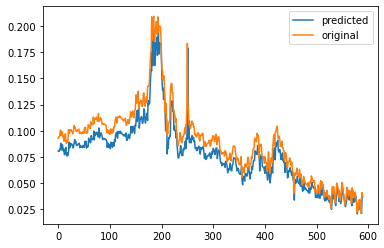

In [14]:
import matplotlib.pyplot as plt

test_set = NGTimeSeries(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,10,1)).view(-1)
plt.plot(test_pred.detach().numpy(),label='predicted')
plt.plot(test_set[:][1].view(-1),label='original')
plt.legend()
plt.show()

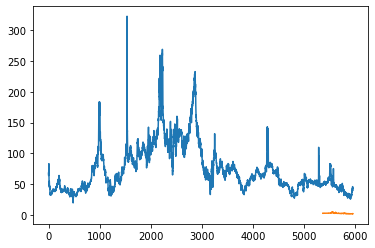

In [16]:
y = y * (maxm - minm) + minm
y_pred = test_pred.detach().numpy() * (maxm - minm) + minm
plt.plot(y)
plt.plot(range(len(y)-len(y_pred), len(y)), y_pred)
plt.show()

In [27]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random


# Define a class to load and preprocess the surname data
class SurnameDataset(Dataset):
    def __init__(self, data_folder, sequence_length=20):
        self.languages = {}
        self.languages_index = {}
        self.languages_list = []
        self.surname_data = []
        self.sequence_length = sequence_length

        # Load surname data from files
        for filename in glob.glob(data_folder + '/*.txt'):
            language = os.path.splitext(os.path.basename(filename))[0]
            self.languages_list.append(language)
            self.languages_index[language] = len(self.languages_index)
            with open(filename, 'r', encoding='utf-8') as file:
                surnames = [line.strip() for line in file]
                self.surname_data.extend([(surname, language) for surname in surnames])
                self.languages[language] = surnames

    def __len__(self):
        return len(self.surname_data)

    def __getitem__(self, idx):
        surname, language = self.surname_data[idx]
        # Convert surname characters to one-hot encoding
        surname_tensor = self.surname_to_tensor(surname)
        # Convert language to label index
        language_label = torch.tensor(self.languages_index[language], dtype=torch.long)
        return surname_tensor, language_label

    def surname_to_tensor(self, surname):
        tensor = torch.zeros(self.sequence_length, len(all_letters))
        for i, letter in enumerate(surname):
            tensor[i][all_letters.find(letter)] = 1
        return tensor


# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        output, _ = self.lstm(x, (h0, c0))
        output = self.fc(output[:, -1, :])  # Take the last output only
        return output

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

# Define the training function
def train(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for surnames, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(surnames)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(dataloader)}')


# Define function to predict language from surname
def predict_language(model, surname):
    with torch.no_grad():
        input_tensor = dataset.surname_to_tensor(surname).unsqueeze(0)
        output = model(input_tensor)
        _, predicted_index = torch.max(output, 1)
        predicted_language = dataset.languages_list[predicted_index.item()]
        return predicted_language


# Define a function to randomly sample a surname from the dataset
def random_surname(dataset):
    surname, language = random.choice(dataset.dataset.surname_data)
    return surname


# Load and preprocess the data
data_folder = 'data_names/names'
all_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
n_languages = 18
dataset = SurnameDataset(data_folder)

# Define hyperparameters
input_size = len(all_letters)
hidden_size = 128
output_size = n_languages
learning_rate = 0.001
batch_size = 64
num_epochs = 20

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader objects for train and test sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

# Instantiate the LSTM model, loss function, and optimizer
lstm_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Train the LSTM model
train(lstm_model, train_loader, criterion, optimizer, num_epochs)

# Test the LSTM model
correct = 0
total = 0
with torch.no_grad():
    for surnames, labels in test_loader:
        outputs = lstm_model(surnames)
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set using LSTM: {100 * correct / total:.2f}%')

# Test predictions using LSTM
for i in range(5):
    surname = random_surname(test_set)
    predicted_language = predict_language(lstm_model, surname)


Epoch 1/20, Loss: 1.8645235993472704
Epoch 2/20, Loss: 1.5399042914113201
Epoch 3/20, Loss: 1.443069932945221
Epoch 4/20, Loss: 1.33251675832794
Epoch 5/20, Loss: 1.2035018393242976
Epoch 6/20, Loss: 1.1358936922958647
Epoch 7/20, Loss: 1.053302405127491
Epoch 8/20, Loss: 0.99434472246474
Epoch 9/20, Loss: 0.9314825261731546
Epoch 10/20, Loss: 0.8777138266667902
Epoch 11/20, Loss: 0.8415099420395505
Epoch 12/20, Loss: 0.7981665682982638
Epoch 13/20, Loss: 0.7769775249331121
Epoch 14/20, Loss: 0.7321479097305541
Epoch 15/20, Loss: 0.6955089584527263
Epoch 16/20, Loss: 0.6694521944361379
Epoch 17/20, Loss: 0.6435014794309776
Epoch 18/20, Loss: 0.6132575193961778
Epoch 19/20, Loss: 0.5937901598761282
Epoch 20/20, Loss: 0.5686103243276892
Accuracy on test set using LSTM: 78.98%


In [28]:
torch.save(lstm_model,'pretrained_next_char_lstm.pth')

In [37]:
import torch
import torch.nn as nn
import numpy as np
import random

# Define the LSTM model for next character prediction
class NextCharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(NextCharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

# Function to sample the next character from the output probabilities
def sample_next_char(output):
    probabilities = torch.softmax(output, dim=2).squeeze().detach().numpy()
    next_char_index = np.random.choice(np.arange(len(all_letters)), p=probabilities)
    return all_letters[next_char_index]

# Generate a surname using the next character LSTM model
def generate_surname(model, start_char='A', max_length=20):
    model.eval()
    with torch.no_grad():
        input_char = start_char
        hidden = model.init_hidden(1)
        surname = start_char
        for _ in range(max_length - 1):
            input_tensor = torch.zeros(1, 1, len(all_letters))
            input_tensor[0][0][all_letters.find(input_char)] = 1
            output, hidden = model(input_tensor, hidden)
            next_char = sample_next_char(output)
            if next_char == '\n':
                break
            surname += next_char
            input_char = next_char
    return surname

# List of characters
all_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ\n'  # Include newline character

# Generate training data
def generate_training_data(num_examples=10000, max_length=20):
    data = []
    for _ in range(num_examples):
        surname = ''.join(random.choices(all_letters[:-1], k=max_length))
        target = surname[1:] + '\n'
        data.append((surname, target))
    return data

# Convert surnames to tensors
def surnames_to_tensor(surnames):
    tensor = torch.zeros(len(surnames), len(surnames[0]), len(all_letters))
    for i, surname in enumerate(surnames):
        for j, char in enumerate(surname):
            tensor[i][j][all_letters.find(char)] = 1
    return tensor

# Define hyperparameters
input_size = len(all_letters)
hidden_size = 128
output_size = len(all_letters)
num_layers = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 20

# Create the model
model = NextCharLSTM(input_size, hidden_size, output_size, num_layers)

# Generate training data
training_data = generate_training_data()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    random.shuffle(training_data)
    running_loss = 0.0
    for i in range(0, len(training_data), batch_size):
        batch = training_data[i:i+batch_size]
        surnames, targets = zip(*batch)
        surnames_tensor = surnames_to_tensor(surnames)
        targets_tensor = torch.tensor([all_letters.find(char) for char in ''.join(targets)], dtype=torch.long)
        
        optimizer.zero_grad()
        
        hidden = model.init_hidden(len(batch))
        outputs, _ = model(surnames_tensor, hidden)
        outputs = outputs.view(-1, len(all_letters))
        
        loss = criterion(outputs, targets_tensor)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(training_data)}')

# Generate a few surnames using the trained model
for _ in range(5):
    generated_surname = generate_surname(model, start_char=random.choice(all_letters[:-1]))
    print("Generated Surname:", generated_surname)


Epoch 1/20, Loss: 0.060538402247428895
Epoch 2/20, Loss: 0.0596951642036438
Epoch 3/20, Loss: 0.06067319498062134
Epoch 4/20, Loss: 0.0615887895822525
Epoch 5/20, Loss: 0.05991711730957031
Epoch 6/20, Loss: 0.05948990776538849
Epoch 7/20, Loss: 0.05974711375236511
Epoch 8/20, Loss: 0.05910717856884003
Epoch 9/20, Loss: 0.05901520910263062
Epoch 10/20, Loss: 0.05898163843154907
Epoch 11/20, Loss: 0.05896468968391418
Epoch 12/20, Loss: 0.05895895941257477
Epoch 13/20, Loss: 0.05895258567333221
Epoch 14/20, Loss: 0.0610471577167511
Epoch 15/20, Loss: 0.062410000395774844
Epoch 16/20, Loss: 0.05976515913009644
Epoch 17/20, Loss: 0.05965051290988922
Epoch 18/20, Loss: 0.06239033644199371
Epoch 19/20, Loss: 0.060222954964637754
Epoch 20/20, Loss: 0.059396429634094236
Generated Surname: nSzPdICGOMAeAAcprCEJ
Generated Surname: EBONVrHgqeSDwOkQov
Generated Surname: BAjmJJqxLHkhWyOgcYyI
Generated Surname: VUPS
Generated Surname: AKNeAAIeuoCSFoqrQpHG
